# Исследование заведений общественного питания в Москве

Необходимо изучить рынок заведений общественного питания в Москве.
Набор данных содержит информацию об объектах общественного питания.

**Цель исследования**: провести исследовательский анализ открытых данных об объектах общественного питания в г. Москва.

**Ход исследования**:
1. Импорт данных
2. Обзор данных
3. Предварительная обработка данных
4. Исследовательский анализ данных
5. Подготовка [презентации](https://disk.yandex.ru/i/6XMCE_N_DR_JqQ)

**Используемые библиотеки**:
1. pandas
2. matplotlib.pyplot
3. seaborn
4. plotly
5. sklearn


## Импорт данных

Подключение библиотек, необходимых для исследования:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotly import graph_objects as go
import plotly.express as px
from sklearn import preprocessing
from sklearn.cluster import KMeans

Импорт данных:

In [2]:
rest = pd.read_csv('/datasets/rest_data.csv')
rest.head()

,id,object_name,chain,object_type,address,number
0,151635,СМЕТАНА,нет,кафе,"город Москва, улица Егора Абакумова, дом 9",48
1,77874,Родник,нет,кафе,"город Москва, улица Талалихина, дом 2/1, корпус 1",35
2,24309,Кафе «Академия»,нет,кафе,"город Москва, Абельмановская улица, дом 6",95
3,21894,ПИЦЦЕТОРИЯ,да,кафе,"город Москва, Абрамцевская улица, дом 1",40
4,119365,Кафе «Вишневая метель»,нет,кафе,"город Москва, Абрамцевская улица, дом 9, корпус 1",50


## Обзор данных

Для начала, необходимо провести общий обзор данных.

In [3]:
rest.info()
display(rest.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15366 entries, 0 to 15365
Data columns (total 6 columns):
id             15366 non-null int64
object_name    15366 non-null object
chain          15366 non-null object
object_type    15366 non-null object
address        15366 non-null object
number         15366 non-null int64
dtypes: int64(2), object(4)
memory usage: 720.4+ KB


,id,number
count,15366.000000,15366.000000
mean,119720.066901,59.547182
std,73036.130732,74.736833
min,838.000000,0.000000
25%,28524.000000,12.000000
50%,144974.500000,40.000000
75%,184262.250000,80.000000
max,223439.000000,1700.000000


Данные не имеют явных пропусков, а типы данных всех столбцов, кроме ***chain***, соответствуют их смысловому наполнению (строго говоря, тип данных в столбце ***chain*** в дальнейшем можно оставить без изменений, но для удобства вычислений, преобразуем его в boolean на следующем этапе).

В наборе данных присутствует 6 столбцов и 15366 наблюдений. Согласно документации к набору данных:
* ***id*** — идентификатор объекта;
* ***object_name*** — название объекта общественного питания;
* ***chain*** — сетевой ресторан;
* ***object_type*** — тип объекта общественного питания;
* ***address*** — адрес;
* ***number*** — количество посадочных мест.

### Вывод

После предварительного обзора данных можно заключить, что данные являются достаточными для проведения исследования, однако следует удостовериться, что в данных отсутствуют неявные пропуски и дубликаты, а также для дальнейшего удобства вычислений, привести столбец ***chain*** к типу boolean.

## Предварительная обработка данных

Далее необходимо провести предварительную обработку данных и проверить их на наличие дубликатов (как явных, так и неявных) и неявных пропусков.

### Обработка дубликатов

Проверим данные на наличие явных дубликатов:

In [4]:
print(f'Количество явных дубликатов: {rest.duplicated().sum()}')

Количество явных дубликатов: 0


Явные дубликаты в данных отсутствуют, однако, стоит проверить на наличие дубликатов при исключении из рассмотрения столбца ***id***:

In [5]:
print(f'Количество дубликатов при исключении столбца id: {rest.drop("id", axis=1).duplicated().sum()}')

Количество дубликатов при исключении столбца id: 82


Таким образом, обнаружены дубликаты по всем параметром, вплоть до названия объекта общественного питания с разными идентификационными номерами. Вероятнее всего, это может быть вызвано, например, закрытием и повторным открытием точки.

Таких дубликатов немного и на общий ход исследования они значимо не повлияют, однако, стоит исключить их из рассмотрения.

In [6]:
rest = rest[~rest.drop('id', axis=1).duplicated()]

#### Вывод

Неявные дубликаты данных устранены.

### Обработка пропусков

Так как явных пропусков в данных не присутствует, проверим уникальных значения категориальных столбцов:

In [7]:
for col in ['chain', 'object_type']:
    print(rest[col].unique())

['нет' 'да']
['кафе' 'столовая' 'закусочная' 'предприятие быстрого обслуживания'
 'ресторан' 'кафетерий' 'буфет' 'бар' 'магазин (отдел кулинарии)']


#### Вывод

В данных столбцах также отсуствуют неявные пропуски, однако значения "нет" / "да" в столбце ***chain*** лучше привести к типу boolean. В остальных столбцах найти отсутствующие значения вручную проблематично.

### Приведение типов данных

Столбец ***chain*** необходимо привести к типу boolean:

In [8]:
rest.chain = rest.chain.apply(lambda x: False if x == 'нет' else True)

#### Вывод

Тип данных в стобце ***chain*** приведен к boolean

### Обработка аномальных значений

Предварительный обзор данных показал, что в данных присутствуют подозрительно большие значения столбца ***number***. 
Проверим распределение данного столбца:

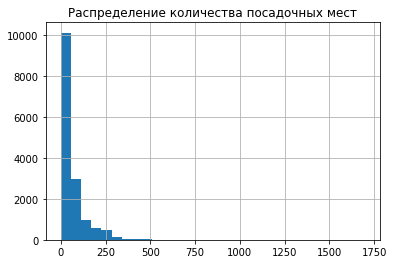

In [9]:
rest.number.hist(bins=30);
plt.title('Распределение количества посадочных мест');

Посмотрим детальнее на объекты без посадочных мест, а также на объекты с аномально большим числом посадочных мест:

In [10]:
print(f'Количество объектов с 0 или 1 посадочным местом: {len(rest[rest.number < 2])}')
display(rest[rest.number < 2].head())
print(f'Количество объектов более, чем с 1000 посадочных мест: {len(rest[rest.number > 1000])}')
display(rest[rest.number > 1000].head())

Количество объектов с 0 или 1 посадочным местом: 1689


,id,object_name,chain,object_type,address,number
137,115498,Пекарня & Донер,False,закусочная,"город Москва, Бутырская улица, дом 9, корпус 2",0
154,152556,Шаурма в пите,False,предприятие быстрого обслуживания,"город Москва, Варшавское шоссе, дом 72, корпус 2",0
157,149568,Суши,False,предприятие быстрого обслуживания,"город Москва, улица Маршала Василевского, дом ...",0
190,126956,"Шаурма, куры-гриль",False,предприятие быстрого обслуживания,"город Москва, 1-я Владимирская улица, дом 21",0
195,149531,"Шаурма, куры-гриль",False,предприятие быстрого обслуживания,"город Москва, 2-я Владимирская улица, дом 44/10",0


Количество объектов более, чем с 1000 посадочных мест: 7


,id,object_name,chain,object_type,address,number
2313,26560,Ресторан «АЛЬФА»,False,ресторан,"город Москва, Измайловское шоссе, дом 71, корп...",1040
3686,27026,РУМ СЕРВИС,False,ресторан,"город Москва, площадь Европы, дом 2",1200
4480,27024,РУМ СЕРВИС,False,ресторан,"город Москва, Кутузовский проспект, дом 2/1, с...",1200
8148,80291,Банкетный зал Шелк,False,ресторан,"город Москва, Большой Саввинский переулок, дом...",1500
8345,27750,СТОЛОВАЯ-БУФЕТ,False,столовая,"город Москва, улица Волхонка, дом 15",1400


#### Вывод
Исключать данные объекты из рассмотрения не будем,так как довольно затруднительно проверить характер таких явлений для каждого объекта (то есть, например, в предприятиях быстрого питания - 0 посадочных мест вполне естественно, а 1700 посадочных мест - это концертная площадка) однако, стоит принять во внимание, что рассчитывать среднее по неагрегированным значениям в таком случае не нужно. В ходе исследования будем пользоваться медианными значениями, если они потребуются.

## Исследовательский анализ данных

В ходе исследования будет произведен анализ различных параметров объектов общественного питания. По результату каждого этапа исследования будет представлена таблица с русскоязычными обозначениями, а также график (опционально) и соответствующие выводы.

### Исследование видов объектов общественного питания

На первом этапе исследования, проверим распределение количества объектов по типу объекта. Здесь и далее основные сводные таблицы будем сохранять для возможности последующей выгрузки.

In [11]:
stat_type = rest.groupby('object_type')['id'].count().reset_index()
stat_type.columns = ['Тип объекта', 'Количество объектов']
stat_type

,Тип объекта,Количество объектов
0,бар,855
1,буфет,577
2,закусочная,349
3,кафе,6071
4,кафетерий,395
5,магазин (отдел кулинарии),273
6,предприятие быстрого обслуживания,1898
7,ресторан,2282
8,столовая,2584


#### Вывод

Нетрудно заметить, что подавляющее большинство объектов общественного питания принадлежит к типу "кафе" *(6071 объект)*. 

За ними почти одинаковое количество объектов имеют типы "столовая" *(2584 объектов)*, "ресторан" *(2282 объектов)* и "предприятия быстрого обслуживания" *(1898 объектов)*. 

Остальные типы объектов составляют менее 6% объема данных каждый. Меньше всего объектов с типом "кулинария" *(273 объекта)*

### Исследование количества сетевых и несетевых объектов

На данном этапе будет установлено абсолютное и относительное соотношение между объектами с сетевым и несетевым типом распространения.

In [13]:
stat_chain = rest.groupby('chain')['id'].count().reset_index()
stat_chain.columns = ['Тип объекта', 'Количество объектов']
stat_chain['Доля'] = round(stat_chain['Количество объектов'] / stat_chain['Количество объектов'].sum() * 100, 2)
stat_chain.replace([False, True], ['несетевые', 'сетевые'], inplace=True)
stat_chain

,Тип объекта,Количество объектов,Доля
0,несетевые,12320,80.61
1,сетевые,2964,19.39


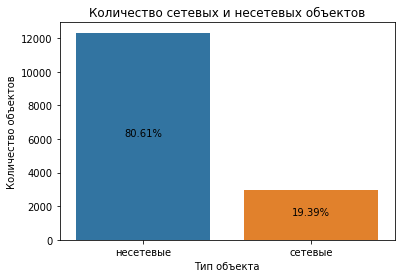

In [14]:
ax = sns.barplot(data=stat_chain, x='Тип объекта', y='Количество объектов');
plt.title('Количество сетевых и несетевых объектов');
for p, t in zip(ax.patches, stat_chain['Доля']) :
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{t}%', (x + width/2, y + height/2), ha='center')

#### Вывод

Более 80% представленных объектов (12320 объектов) не являются сетевыми.

### Исследование зависимости вида объекта и типа распространения

На данном этапе исследуется зависимость типа объекта и типа его распространения:

In [15]:
stat_type_chain = rest.pivot_table(index=['object_type'], columns='chain', values='id', aggfunc='count').reset_index()
stat_type_chain.columns = ['Тип объекта', 'Несетевых объектов', 'Сетевых объектов']
stat_type_chain.replace(['магазин (отдел кулинарии)', 'предприятие быстрого обслуживания'], 
                        ['магазин', 'быстрое обслуживание'], inplace=True)

stat_type_chain['доля сетевых объектов'] = round((stat_type_chain['Сетевых объектов'] / 
                                                 (stat_type_chain['Сетевых объектов'] + 
                                                  stat_type_chain['Несетевых объектов'])) * 100, 2)
stat_type_chain['доля несетевых объектов'] = round((stat_type_chain['Несетевых объектов'] / 
                                                   (stat_type_chain['Сетевых объектов'] + 
                                                    stat_type_chain['Несетевых объектов'])) * 100, 2)

stat_type_chain

,Тип объекта,Несетевых объектов,Сетевых объектов,доля сетевых объектов,доля несетевых объектов
0,бар,818,37,4.33,95.67
1,буфет,566,11,1.91,98.09
2,закусочная,293,56,16.05,83.95
3,кафе,4675,1396,22.99,77.01
4,кафетерий,343,52,13.16,86.84
5,магазин,195,78,28.57,71.43
6,быстрое обслуживание,1110,788,41.52,58.48
7,ресторан,1739,543,23.79,76.21
8,столовая,2581,3,0.12,99.88


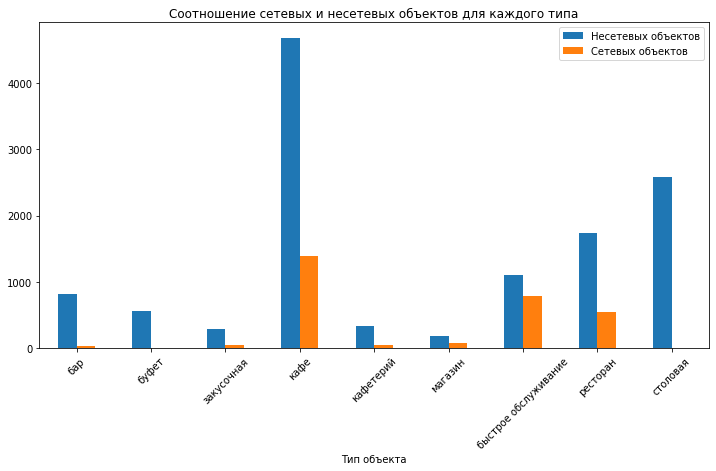

In [16]:
stat_type_chain.plot.bar(x='Тип объекта', y=['Несетевых объектов', 'Сетевых объектов'], figsize=(12, 6));
plt.xticks(rotation=45);
plt.title('Соотношение сетевых и несетевых объектов для каждого типа');

#### Вывод

Результаты этого исследования являются интуитивно согласующимися. Выводы представлены в порядке уменьшения количества общего количества объектов. Таким образом:

* Как уже было установлено ранее, тип "кафе" является самым распространенным. Внутри типа количество несетевых объектов составляет более 77%.
* На втором месте по количеству объектов располагается тип "столоая", в котором менее 1% сетевых объектов.
* Далее по следует тип "ресторан" в котором более 76% несетевых объектов, причём стоит обратить внимание на то, что относительное количество сетевых объектов у ресторанов выше.
* Следующий тип объекта - "быстрое обслуживание". Здесь интересен тот факт, что доля сетевых объектов составляет более 41%, что говорит о том, что сетевой тип распространения наиболее характерен для объектов быстрого обслуживания.
* Последующие типы не представляют существенного интереса, так как их доля в общем объеме данных мала, но следует обратить внимание на тот факт, что сетевое распространение также отчасти характерно для магазинов-кулинарий (более 28%). 

In [17]:
rest.groupby('object_type').apply(lambda group: pd.Series(dict(доля_сетевых=group['chain'].mean().round(2),
                                                               доля_несетевых=(group['chain'] == False).mean().round(2))))

,доля_сетевых,доля_несетевых
object_type,,
бар,0.04,0.96
буфет,0.02,0.98
закусочная,0.16,0.84
кафе,0.23,0.77
кафетерий,0.13,0.87
магазин (отдел кулинарии),0.29,0.71
предприятие быстрого обслуживания,0.42,0.58
ресторан,0.24,0.76
столовая,0.00,1.00


### Исследование количества посадочных мест и количества объектов в сетевых заведениях

На данном исследования устанавливается количество посадочных мест и количество объектов внутри каждой сети пунктов общественного питания. 

Данный этап исследования во многом имеет слишком субъективный характер и сильно зависит от степени очистки данных , а также от выбора пороговых значений, которые позволяют судить критериями "мало" / "много".

Важно обратить внимание на то, что использование результатов данного блока без уточнения дополнительных данных, относительно объекта, который планируется открывать, может привнести дополнительные финансовые и временные издержки.

На первом этапе происходит объявление функций, необходимых для очистки и классификации данных:

In [18]:
def name_split(name):
    
    ''' 
        Данная функция принимает на вход название сети объектов и выделяет название,
        убирая лишние слова из строки
    '''
    res = name.lower()
    res = res.split(' «')
    return res[len(res)-1].split('»')[0]

def obj_category(row):
    
    ''' 
        Данная функция принимает на вход медианные строку данных, 
        сгруппированных по названию сети и присваивает каждой сети определенную категорию:
        
        -- мало точек в сети и мало посадочных мест в каждой
        +- много точек в сети и мало посадочных мест в каждой
        -+ мало точек в сети и много посадочных мест в каждой
        ++ много точек в сети и много посадочных мест в каждой
        ?? в том случае, если по каким-то причинам нет входа во все условия
        
        Переменные cmed и mmed в начале тела функции задают пороговые значения
        между "много" и "мало" для количества точек и медианного значения посадочных мест в сети
    '''
    cmed = 5
    mmed= 40
    if row['count_of_obj'] < cmed and row['med_number'] < mmed:
        return('--')
    if row['count_of_obj'] >= cmed and row['med_number'] < mmed:
        return('+-')
    if row['count_of_obj'] >= cmed and row['med_number'] >= mmed:
        return('++')
    if row['count_of_obj'] < cmed and row['med_number'] >= mmed:
        return('-+')
    return '??'

Также стоит обратить внимание на то, что все объекты, количество которых в сети равно единице будут исключены из рассмотрения по следующим причинам:
1. Возможно, данные точки являются следствием довольно грубой очистки названий сетей. 
2. Возможно, данные точки являются сетевыми, но в Москве, действительно, располагается только 1 объект.

In [19]:
stat_chain_number = rest[rest.chain==True].copy() # только сетевые объекты
stat_chain_number['new_name'] = stat_chain_number['object_name'].apply(name_split) # очистка названий
stat_chain_number = stat_chain_number.pivot_table(index='new_name', 
                                                  values='number', 
                                                  aggfunc=['count', 'median']).reset_index() # сведение очищенных данных
stat_chain_number.columns = ['name', 'count_of_obj', 'med_number']
stat_chain_number = stat_chain_number[stat_chain_number.count_of_obj > 1] #исключение сетей с 1 объектом
stat_chain_number['categ'] = stat_chain_number.apply(obj_category, axis=1) #категоризация сгруппированных данных

In [20]:
stat_chain_number.head()

,name,count_of_obj,med_number,categ
3,bocconcino,3,68.0,-+
7,burger club,3,20.0,--
9,coffeeshop company,4,50.0,-+
10,cofix,25,10.0,+-
12,correas,3,32.0,--


Далее данные повторно группируются, но в этот раз по присвоенной категории:

In [21]:
stat_cn_cat = stat_chain_number.groupby('categ')['name'].count().to_frame().reset_index()
stat_cn_cat.columns = ['Категория', 'Количество']
stat_cn_cat['Доля'] = round(stat_cn_cat['Количество'] / stat_cn_cat['Количество'].sum() * 100, 2)
stat_cn_cat

,Категория,Количество,Доля
0,++,52,25.49
1,+-,48,23.53
2,-+,60,29.41
3,--,44,21.57


Принятые обозначения категорий:
* -- мало точек в сети и мало посадочных мест в каждой
* +- много точек в сети и мало посадочных мест в каждой
* -+ мало точек в сети и много посадочных мест в каждой
* ++ много точек в сети и много посадочных мест в каждой

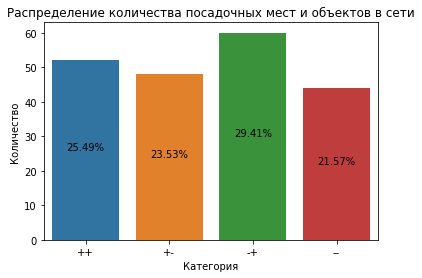

In [22]:
ax = sns.barplot(data=stat_cn_cat, x='Категория', y='Количество');
plt.xticks(rotation=0);
plt.title('Распределение количества посадочных мест и объектов в сети');
for p, t in zip(ax.patches, stat_cn_cat['Доля']) :
    width = p.get_width()
    height = p.get_height()
    x, y = p.get_xy() 
    ax.annotate(f'{t}%', (x + width/2, y + height/2), ha='center')

#### Вывод

Как уже ранее было замечено, делать строгие выводы по данному исследованию довольно сложно, так как присутствует довольно значимый субъективный фактор. 

Однако, принимая во внимание всё вышесказанное, можно заключить, что в ходе исследования получены следующие результаты: при заданных пороговых значениях (5 для количества объектов в сети, 40 для медианного количества посадочных мест), которые характерирузют переход от "мало точек в сети / мало посадочных мест" к "много", можно заключить, что немного выделяется категория "мало объектов в сети с большим количеством посадочных мест".



### Исследование количества посадочных мест в объектах разных типов

На данном этапе исследуется распределение медианного количества посадочных мест в разрезе типа объекта общественного питания.

In [23]:
stat_type_number = rest.pivot_table(index='object_type', columns='chain', values='number', aggfunc='median').reset_index()
stat_type_number = stat_type_number.merge(rest.pivot_table(index='object_type', values='number', 
                                                           aggfunc='median').reset_index(), on='object_type', how='left')
stat_type_number.columns = ['Тип', 'Сетевые объекты', 'Несетевые объекты', 'По типу в целом']
stat_type_number.replace(['магазин (отдел кулинарии)', 'предприятие быстрого обслуживания'],
                         ['кулинария', 'быстрое обслуживание'], inplace=True)
stat_type_number


,Тип,Сетевые объекты,Несетевые объекты,По типу в целом
0,бар,34.0,45.0,35
1,буфет,32.0,0.0,32
2,закусочная,0.0,8.0,0
3,кафе,30.0,40.0,30
4,кафетерий,6.0,8.0,6
5,кулинария,0.0,3.5,0
6,быстрое обслуживание,0.0,25.0,6
7,ресторан,75.0,89.0,80
8,столовая,103.0,120.0,103


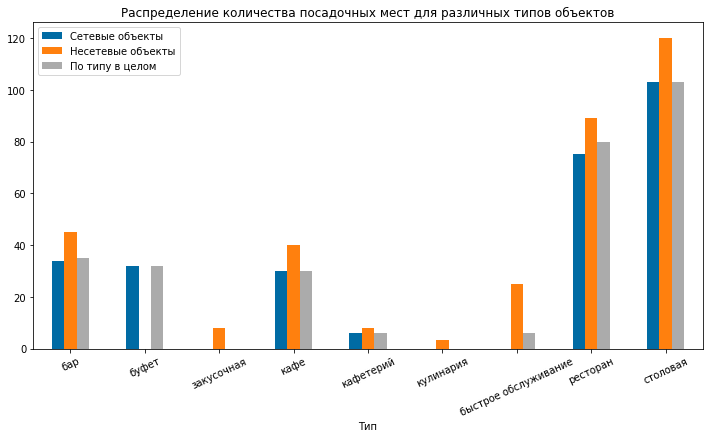

In [24]:
with plt.style.context('tableau-colorblind10'):    
    stat_type_number.plot.bar(x='Тип', y=['Сетевые объекты', 'Несетевые объекты', 'По типу в целом'], figsize=(12, 6))
    plt.xticks(rotation=25);
    plt.title('Распределение количества посадочных мест для различных типов объектов');

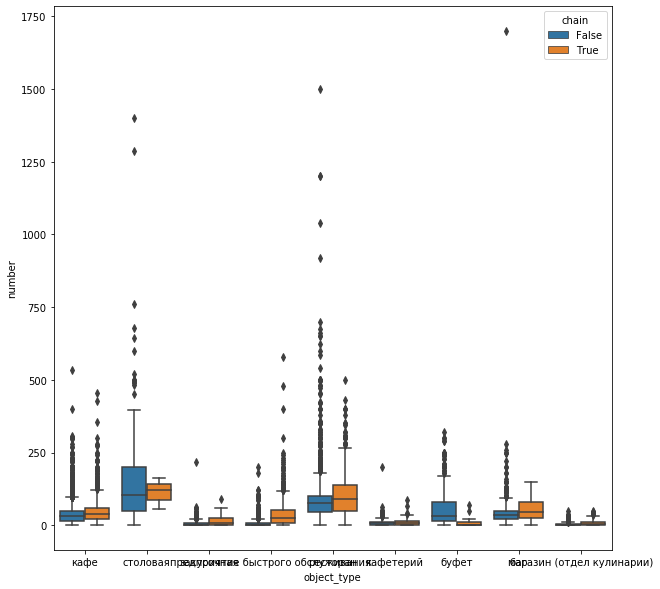

In [25]:
plt.figure(figsize=(10,10))
sns.boxplot(data=rest, x='object_type', y='number', hue='chain');

#### Вывод

Данное исследование наглядно показывает, что количество посадочных мест сильно зависит от типа заведения, а также для некоторых типов объектов зависит от того, является ли объект сетевым. Таким образом:
* Для столовых, особенно несетевых, характерно самое большое медианное значение, относительно других типов объектов. Это косвенно подтверждает саму идеологию таких заведений, т.е. невысокую цена питания и много посадочных мест, для того, чтобы выдержать поток клиентов в часы пиковой загрузки (например, обеденное время у сотрудников соседнего бизнес-центра).
* На втором месте идут рестораны, причём, для несетевых ресторанов характерно большее количество посадочных мест, чем для сетевых. В ресторанах медианное значение количества посадочных мест тоже довольно высокое, так как в ресторанах цены, как правило, выше, чем в столовых, но при этом посетители там тоже могут проводить довольно много времени, в связи с чем малое количество посадочных мест может просто не перекрыть поток клиентов в пиковые нагрузочные часы.
* Далее приблизительно одинаковые значения у кафе, буфетов и баров. Причём относительное отношение между несетевыми и сетевыми объектами повторяет вариант ресторанов, то есть, количество посадочных мест у несетевых объектов больше.
* Затем следуют закусочные, кафетерии, кулинарии и точки быстрого обслуживания с минимальным количеством посадочных мест, что также подтверждает сам принцип данных заведений: либо "еда на ходу", либо "зайти ненадолго".

### Исследование улиц с максимальным и минимальным количеством объектов

Для начала необходимо импортировать дополнительный набор данных из внешнего источника. В качестве идентифицации улицы по округу и району будет использован [материал](https://docs.google.com/spreadsheets/d/1CPDYDGjKCb6jGoQt9KR5WOvTspK-dHS3NUrVeqsyqJs/edit#gid=2139935940):

In [26]:
spreadsheet_id = '18CzZ6iDvVxxVri9WYJTM4oeOr9Bf14tmFJo-1pIUVZs'
file_name = 'https://docs.google.com/spreadsheets/d/{}/export?format=csv'.format(spreadsheet_id)
info_street = pd.read_csv(file_name)
info_street.streetname = info_street.streetname.str.lower().str.strip()
info_street.drop_duplicates(inplace=True)

На данном этапе выделяется 10 улиц с самым большим количеством объектов питания, а также рассматриваются улицы с минимальным количеством объектов питания.

Для начала необходимо объявить функцию, которая выделит название улицы из полного адреса объекта общественного питания:

In [27]:
def street(address):
    '''
        На вход функция принимает полный адрес объекта и по заготовленному шаблону
        выделяет название улицы
    '''
    stype = ['улица', 'шоссе', 'проезд', 'переулок', 'проспект',
             'бульвар', 'площадь', 'набережная', 'квартал', 'аллея', 'линия']
    res = address.lower()
    res = res.split(', ')
    for i in res:
        for j in stype:
            if i.find(j) >= 0:
                return i
    return 'unknown street'

In [28]:
rest['street'] = rest['address'].apply(street)

Для начала необходимо сгруппировать все данные по названиям улиц и исключить из рассмотрения улицы, которые функция не смогла идентифицировать (исключаются улицы с неоднозначным названием, которое может принадлежать как к городу, так и к непосредственно улице). Таких объектов не очень много, поэтому их исключение не приведет к существенной потере данных и принципиально не изменит характер выводов.

In [29]:
stat_street = rest.pivot_table(index='street', values='id', aggfunc='count').sort_values(by='id', ascending=False).reset_index()
stat_street = stat_street[stat_street['street'] != 'unknown street']
stat_street.columns = ['Улица', 'Количество объектов']

Далее выделяются 10 улиц с самым большим количеством объектов общественного питания. Для каждый улицы будет установлен округ и район (информация получена из внешних источников):

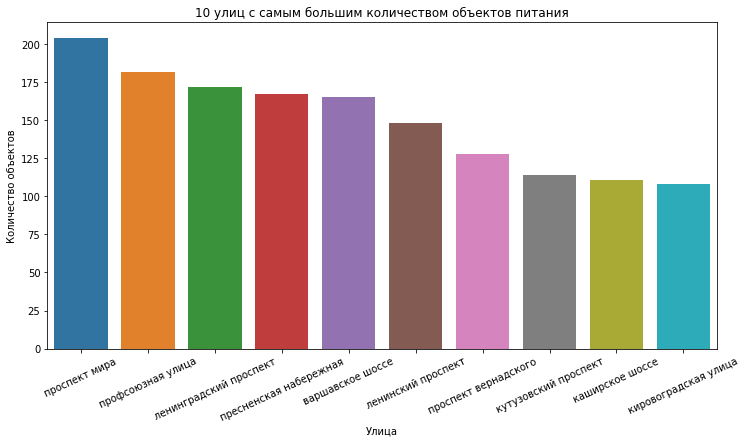

In [30]:
stat_street_top_10 = stat_street.head(10)
plt.figure(figsize=(12, 6))
sns.barplot(data=stat_street_top_10, x='Улица', y='Количество объектов');
plt.xticks(rotation=25);
plt.title('10 улиц с самым большим количеством объектов питания');

In [31]:
stat_street_top_10 = stat_street_top_10.merge(info_street, how='left', left_on='Улица', right_on='streetname')
stat_street_top_10.drop(['streetname', 'areaid'], axis=1, inplace=True)
stat_street_top_10.columns = ['Улица', 'Количество объектов', 'Округ', 'Район']
stat_top_10_area = stat_street_top_10.groupby('Район')['Округ'].count().to_frame()
stat_top_10_area.columns = ['Количество улиц']
display(stat_top_10_area)

,Количество улиц
Район,
Академический район,1
Алексеевский район,1
Донской район,2
Ломоносовский район,2
Мещанский район,1
Нагорный район,1
Обручевский район,2
Останкинский район,1
Пресненский район,1


Проверим, через сколько районов проходят 10 улиц с самым большим количеством объектов:

In [32]:
stat_area_top_10 = (stat_street_top_10.
                    groupby('Улица')['Район'].
                    count().
                    to_frame().
                    sort_values(by='Район', ascending=False).
                    reset_index())
stat_area_top_10.columns = ['Улица', 'Количество районов']
stat_area_top_10

,Улица,Количество районов
0,варшавское шоссе,8
1,ленинский проспект,8
2,проспект мира,7
3,профсоюзная улица,6
4,проспект вернадского,5
5,каширское шоссе,4
6,ленинградский проспект,4
7,кировоградская улица,3
8,кутузовский проспект,2
9,пресненская набережная,1


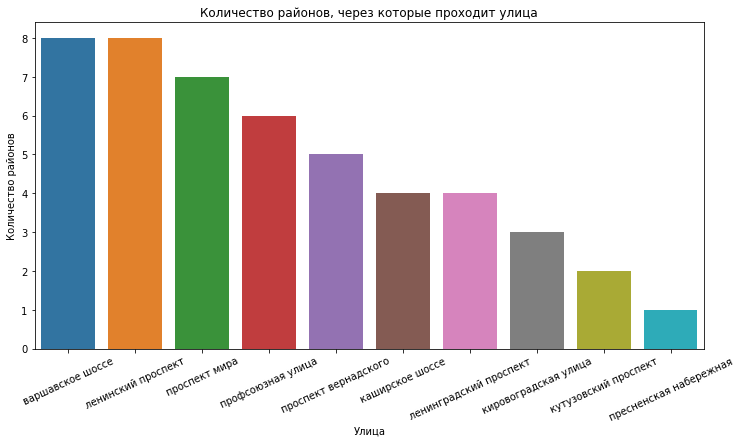

In [33]:
plt.figure(figsize=(12, 6))
sns.barplot(data=stat_area_top_10, x='Улица', y='Количество районов');
plt.xticks(rotation=25);
plt.title('Количество районов, через которые проходит улица');

К качестве дополнительной информации можно добавить в рассмотрение 10 самых "плотных" улиц по количеству объектов питания:

In [34]:
stat_dens = stat_street.merge(info_street, how='left', left_on='Улица', right_on='streetname')
stat_dens = stat_dens.groupby('Улица')['area'].count().to_frame().reset_index()
stat_dens.columns = ['Улица', 'Количество районов']
stat_dens = stat_dens.merge(stat_street, how='right', on='Улица')
stat_dens = stat_dens[stat_dens['Количество районов'] > 0]
stat_dens['Плотность'] = stat_dens['Количество объектов'] / stat_dens['Количество районов']
stat_dens = stat_dens.sort_values(by='Плотность', ascending=False).head(10)
stat_dens

,Улица,Количество районов,Количество объектов,Плотность
1025,пресненская набережная,1,167,167.0
1816,ходынский бульвар,1,102,102.0
1619,улица новый арбат,1,92,92.0
1536,улица ленинская слобода,1,89,89.0
1086,пятницкая улица,1,80,80.0
1649,улица покровка,1,77,77.0
1347,улица арбат,1,77,77.0
1263,тверская улица,1,68,68.0
231,автозаводская улица,1,67,67.0
1885,ярославское шоссе,1,65,65.0


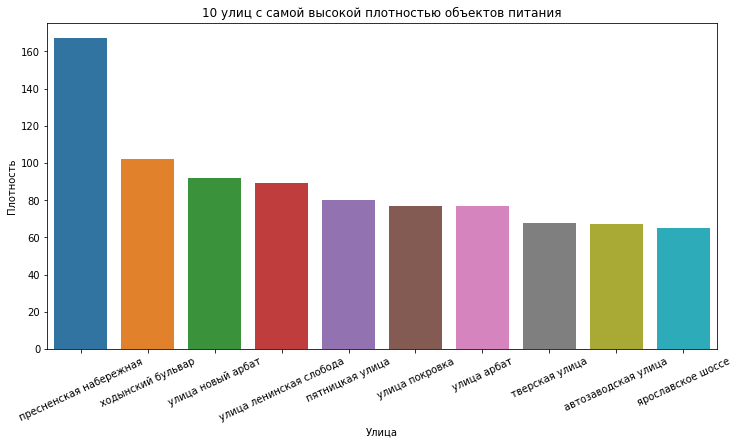

In [35]:
plt.figure(figsize=(12, 6))
sns.barplot(data=stat_dens, x='Улица', y='Плотность');
plt.xticks(rotation=25);
plt.title('10 улиц с самой высокой плотностью объектов питания');

Улицы с большим количеством объектов являются протяженными, поэтому справедливо, что они проходят через несколько округов и районов.

Далее выделяются улицы, на которых располагается только 1 пункт общественного питания и рассчитываются аналогичные показатели:

In [36]:
stat_street_one_object = stat_street[stat_street['Количество объектов'] == 1]
print(f'Количество улиц с одним объектом общественного питания: {len(stat_street_one_object)}')
stat_street_one_object = stat_street_one_object.merge(info_street, how='left', left_on='Улица', right_on='streetname')
stat_street_one_object.drop(['Количество объектов', 'streetname', 'areaid'], axis=1, inplace=True)
stat_street_one_object.columns = ['Улица', 'Округ', 'Район']
stat_one_object_area = stat_street_one_object.groupby('Район')['Округ'].count().to_frame()
stat_one_object_area.columns = ['Количество улиц']
stat_one_object_area = stat_one_object_area.sort_values(by='Количество улиц', ascending=False)
display(stat_one_object_area.head(10))

Количество улиц с одним объектом общественного питания: 543


,Количество улиц
Район,
Район Хамовники,26
Таганский район,25
Басманный район,24
Тверской район,20
Пресненский район,19
Район Арбат,18
Район Марьина роща,18
Мещанский район,16
Район Замоскворечье,14


#### Вывод

На основании данного исследования можно сделать несколько выводов:
1. Улицы с большим количеством объектов, как правило, сами по себе являются очень протяженными, поэтому сам факт такого количества объектов является абсолютно логичным. Причём важно понимать, что данный тезис никак не коррелирует с популярностью заведений, а отражает лишь их численность. Данные улицы, в большинстве своем проходят через несколько округов и, тем более, районов. Важно заметить, что также есть улицы с высокой плотностью объектов. Такие улицы располагаются в центре и являются местами скопления большого количества людей.
2. На 543 улицах расположено всего по одному объекту, что свидетельствует о двух тезисах: во-первых, сами улицы не являются очень протяженными; во-вторых, они располагаются либо в спальных районах Москвы, либо наоборот ближе к центру. В случае спальных районов не требуется большое количество объектов общественного питания, а в случае улиц, близких к центру, сами улицы являются непротяженными, поэтому на них и располагается всего 1 объект. Те улицы, которые не были однозначно выделены из адреса, вероятнее всего, так же принадлежат к этой категории.
3. Улицы с промежуточным количеством объектов, вероятнее всего, располагаются также ближе к центру Москвы, где и сосредоточена основаная активность горожан, либо к отдаленным от центра, например, торговым центрам.

### Исследование объектов на улицах с большим количеством пунктов питания

На данном этапе исследуются объекты, находящиеся на улицах более чем с 50 объектами.

In [37]:
street_list = stat_street[stat_street['Количество объектов'] > 50]
big_street = rest.merge(street_list, how='inner', left_on='street', right_on='Улица')
big_street = big_street.loc[:, 'id':'street']

#### Взаимосвязь объектов

Для начала необходимо изучить корреляцию количества объектов, располагающихся на таких улицах, с медианным количеством посадочных мест:

In [38]:
stat_big_street_corr = big_street.pivot_table(index='street',
                                              values='number', aggfunc=['count', 'median'])#.reset_index()
stat_big_street_corr.columns = ['Количество объектов', 'Медиана посадочных мест']
stat_big_street_corr.index.name = 'Улица'
stat_big_street_corr.head()

,Количество объектов,Медиана посадочных мест
Улица,,
автозаводская улица,67,20.0
алтуфьевское шоссе,82,33.5
варшавское шоссе,165,30.0
волгоградский проспект,63,49.0
дмитровское шоссе,100,40.0


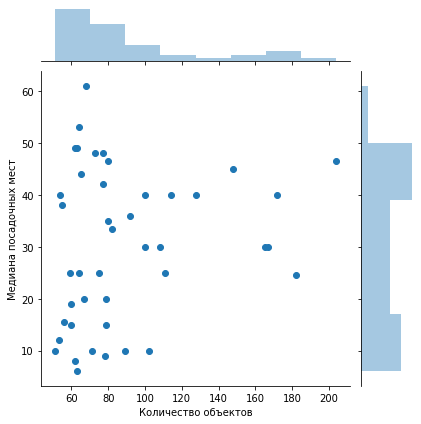

In [39]:
sns.jointplot(data=stat_big_street_corr, x='Количество объектов', y='Медиана посадочных мест');

При таком распределении говорить о линейной корреляции некорректно (хотя, визуально, конечно, вполне допустимо установить положительную корреляцию), поэтому для данной задачи более справедливым подходом будет решить задачу кластеризации:

In [40]:
norm = preprocessing.StandardScaler() #модель стандартизации данных
norm.fit(stat_big_street_corr); # обучение модели стандартизации
stat_big_street_corr_norm = pd.DataFrame(norm.transform(stat_big_street_corr), 
                               index=stat_big_street_corr.index, 
                               columns=stat_big_street_corr.columns) # обновленные данные

Количество кластеров будет выбрано следующим образом: как только при увеличении количества кластеров сумма "расстояний" между ними перестанет значительно уменьшаться, данный граничный переход будет принят за достаточное количество кластеров.

In [41]:
models = [KMeans(n_clusters=i, random_state=76).fit(stat_big_street_corr_norm) for i in range(1, 11)] #генерация моделей
inert = [models[i].inertia_ for i in range(0, len(models))] # сумма "расстояний" между кластерами

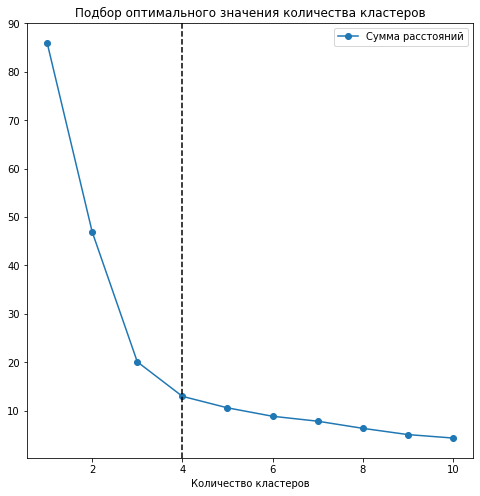

In [42]:
plt.figure(figsize=(8, 8));
plt.plot(range(1, 11), inert, marker='o', label='Сумма расстояний');
plt.xlabel('Количество кластеров');
plt.legend()
plt.title('Подбор оптимального значения количества кластеров');
plt.axvline(4, c='k', linestyle='dashed');

Таким образом, 4 кластера является достаточным количеством для представленного набора данных.

In [43]:
stat_big_street_corr['clusters'] = models[3].labels_

Теперь необходимо изучить различия кластеров:

In [44]:
stat_cluster = stat_big_street_corr.pivot_table(index='clusters', values=['Количество объектов', 'Медиана посадочных мест'], 
                                 aggfunc=['median', 'count'])
stat_cluster.columns = stat_cluster.columns.map(''.join)
stat_cluster.drop('countМедиана посадочных мест', axis=1, inplace=True)
stat_cluster.columns = ['Медиана количества объектов', 'Медиана посадочных мест', 'Количество объектов в кластере']
stat_cluster

,Медиана количества объектов,Медиана посадочных мест,Количество объектов в кластере
clusters,,,
0,100.0,35.0,9
1,169.5,35.0,6
2,65.0,48.0,11
3,64.0,15.0,17


0 - кластер, содержащий улицы со большим количеством объектов питания в пределах улицы и средней медианой посадочных мест;

1 - кластер, содержащий улицы c очень большим количеством объектов питания в пределах улицы и средней медианой посадочных мест;

2 - кластер, содержащий улицы со средним количеством объектов питания в пределах улицы и высокой медианой посадочных мест;

3 - кластер, содержащий улицы со средним количеством объектов питания в пределах улицы и малой медианой посадочных мест;

##### Вывод

Решение данной задачи позволяет приблизительно оценить количество посадочных мест, которое распространено для определенных типов улиц с большим количеством объектов. Таким образом, можно заключить, что для улиц с большим количеством объектов наиболее характерно ~ 64 объекта общественного питания и довольно мало (~ 15) посадочных мест.

Далее для улиц с большим количеством объектов необходимо изучить распределение столбцов *chain*, *object_type* и *number*.

#### Распределение сетевых и несетевых пунктов для улиц с большим количеством объектов

In [45]:
stat_big_chain = big_street.groupby('chain')['id'].count().to_frame().reset_index()
stat_big_chain['perc'] = round(stat_big_chain.id / stat_big_chain.id.sum() * 100, 2) 
stat_big_chain.columns=['Сетевой объект', 'Количество', 'Процент']

In [46]:
stat_big_chain

,Сетевой объект,Количество,Процент
0,False,2903,75.23
1,True,956,24.77


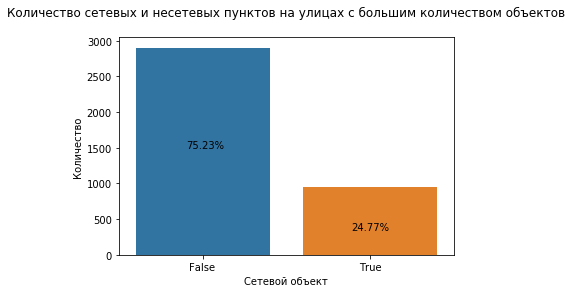

In [47]:
sns.barplot(data=stat_big_chain, x='Сетевой объект', y='Количество');
plt.text(-0.1, 1500, str(float(stat_big_chain.loc[stat_big_chain['Сетевой объект'] == False, 
                                                  'Процент'])) + '%');
plt.text(0.89, 350, str(float(stat_big_chain.loc[stat_big_chain['Сетевой объект'] == True, 
                                                 'Процент'])) + '%');
plt.title('Количество сетевых и несетевых пунктов на улицах с большим количеством объектов\n');

##### Вывод

Если сравнивать полученный результат с результатом, полученным в разделе 4.2, то можно заметить, что на улицах с большим количеством объектов распределение несколько смещается в сторону сетевых объектов, хотя при этом, подавляющее количество объектов всё же несетевые.

#### Типы объектов на улицах с большим количеством пунктов питания

In [48]:
stat_big_type = big_street.groupby('object_type')['id'].count().to_frame().reset_index()
stat_big_type.replace(['магазин (отдел кулинарии)', 'предприятие быстрого обслуживания'], 
                      ['кулинария', 'быстрое обслуживание'], inplace=True)
stat_big_type.columns = ['Тип', 'Количество']
stat_big_type

,Тип,Количество
0,бар,231
1,буфет,80
2,закусочная,65
3,кафе,1733
4,кафетерий,113
5,кулинария,61
6,быстрое обслуживание,574
7,ресторан,708
8,столовая,294


##### Вывод

Если сравнивать представленное распределение типов с распределением по всему набору данных, то можно заметить отсутствие принципиальных отличий. Доли объектов несколько изменились, но изменения нельзя назвать хоть сколько-нибудь значительно влияющими на выводы.

#### Распределение количества посадочных мест на улицах с большим количеством объектов

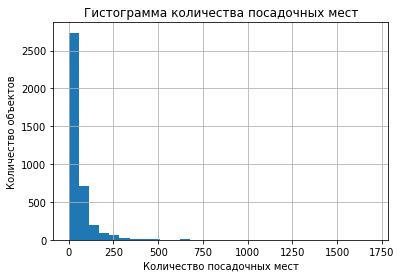

In [50]:
big_street.number.hist(bins=30);
plt.title('Гистограмма количества посадочных мест');
plt.xlabel('Количество посадочных мест');
plt.ylabel('Количество объектов');

##### Вывод

Как и "в целом" по набору данных, большинство заведений стремится к малому числу посадочных мест.

#### Вывод

Выборка по улицам с большим количеством объектов в точности отражает общую картину по набору данных в целом, что является довольно справледливым, так как в рассмотрении участвуют довольно протяженные улицы и внутри каждой из них объекты действительно могут располагаться неравномерно. То есть, если рассмотреть отдельно выбранную улицу в разрезе координат каждого объекта, возможно, закономерности будут несколько иными.

### Рекомендации для открытия объекта питания

1. В качестве типа заведения предпочтительнее выбрать "кафе" по следующим причинам:
    - при том, что объектов типа "кафе" довольно много и конкуренция будет высокой, нестандартной и креативной идеей с роботами можно забрать значительную часть посетителей, которые уже предпочитают ходить именно в кафе. Таким образом недостаток большой конкуренции можно превратить в преимущество
    - диапазон цен в таком типе заведения можно сохранять на среднем уровне или даже сделать ниже среднего по категории за счёт исключения оплаты труда живых людей.
    - характер заведения, вероятнее всего, будет очень привлекательным для молодежи (а у молодежи, как правило, доход ниже, чем у людей среднего возраста), что исключает тип "ресторан" и "столовая" (так как в столовых питаются люди, как правило, с более низким доходом).
2. На начальном этапе лучше исключить сетевой тип распространения и проверить, насколько идея с роботами понравится посетителям, чтобы отказаться от лишних издержек.
3. Количество посадочных мест нужно сделать не более 50, так как это немного превышает среднее значение по типу "кафе", но при этом не сильно выделяется в какую-либо из сторон. То есть при таком количестве посадочных мест не избежать очередей при взрывной популярности, но при этом не потребуется платить неоправданно высокую аредну за большую площадь помещения.
4. Географически лучше располагать объект в центральном административном округе Москвы, так как именно этот округ является центром притяжения москвичей и гостей столицы в вечернее время и выходные дни. При этом по-возможности можно учесть фактор платных парковок и организовать небольшую парковочную площадку для посетителей кафе.

### Общий вывод

В ходе работы были выполнены следующие этапы:
1. Был проведен импорт и общий обзор данных.
2. Произведена предварительная обработка данных, обработаны дубликаты и типы данных.
3. Проведен исследовательский анализ данных, подготовлены рекомендации по открытию пункта общественного питания.
4. Подготовлена [презентация](https://disk.yandex.ru/i/6XMCE_N_DR_JqQ)

**Ключевые выводы**:
1. Больше всего в Москве обхектов общественного питания типа "кафе", "столовая", "ресторан" и "предприятие быстрого обслуживания".
2. Более 80% объектов являются несетевыми.
3. Внутри каждого типа объекта питания соотношение сетевых и несетевых объектов неоднородно. Таким образом:
    - Внутри типа "кафе" количество несетевых объектов составляет более 77%.
    - У "столовых" менее 1% сетевых объектов.
    - У "ресторанов" более 76% несетевых объектов.
    - Доля сетевых объектов в пунктах быстрого обслуживания составляет более 41%, что говорит о том, что сетевой тип распространения наиболее характерен для объектов быстрого обслуживания.
    - Прочие типы объектов не представляют существенного интереса, так как их доля в общем объеме данных мала.
4. Для сетевых объектов характерна концепция: "мало объектов в сети с большим количеством посадочных мест", хотя стоит отметить некоторую субъективность данной оценки.
5. Количество посадочных мест сильно зависит от типа заведения, а также для некоторых типов объектов зависит от того, является ли объект сетевым.
6. На протяженных улицах присутствует большое количество пунктов общественного питания, на небольших улицах объектов питания немного.
7. Улицы с большим количеством объектов питания характеризуются следующим образом:
    - Присутствует 4 группы  улиц, из которых преобладает тип со средним количеством объектов на улице - 64 и со средним значением посадочных мест - 15.
    - Немного более 75% несетевых объектов
    - Преобладающий тип объекта питания - "кафе"
